<a href="https://colab.research.google.com/github/lokkuuuu/Machine-Learning-for-medical-image-classification/blob/main/BreastHis_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Histology Image Classfication

## Mounting to Google Drive

In [ ]:
#Mount to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
#Change to working directory
%cd drive/MyDrive/BreakHis/

/content/drive/MyDrive/BreakHis


## Import Necessary Libraries

In [ ]:
#install required libraries
!pip install scikit-plot
#Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import VotingClassifier
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Function

In [ ]:
IMAGE_SIZE = (224, 340)
CROP_SIZE = (224, 224)
BATCH_SIZE = 128
def dataset(ds_path, *,
            train,
            preprocess_fn=None,
            image_size=IMAGE_SIZE,
            crop_size=CROP_SIZE,
            batch_size=BATCH_SIZE):
    """
    Dataset prepocess function by Saini, Manisha and Susan, Seba
    https://github.com/SainiManisha/VGGIN-Net
    """
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)

    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)

    @tf.function
    def augment(images, labels):
        augment_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,[image],tf.float32),images)
        augment_images = tf.ensure_shape(augment_images, images.shape)
        return augment_images, labels

    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        crop_images = crop_layer(images, training = train)
        return crop_images, labels

    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    if preprocess_fn:
        ds = ds.map(preprocess_fn)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [ ]:
def evaluate_report(data,y_pred):
  y_true = []
  for images, labels in data:
    y_true.append(labels.numpy())
  y_true = np.concatenate(y_true)
  y_probas = y_pred
  y_true = np.argmax(y_true, axis=1)
  print('Accuracy: ', accuracy_score(y_true, y_pred))
  print(classification_report(y_true, y_pred))
  plot_confusion_matrix(y_true, y_pred)
  plot_confusion_matrix(y_true, y_pred, normalize=True)

In [ ]:
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
def plot_result(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  #Getting the losses
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  #No of epochs it trained
  epochs_range = history.epoch
  #Plotting Training and Validation accuracy
  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.style.use('ggplot')
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle = "dashed")
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  #Plotting Training and Validation Loss
  plt.subplot(1, 2, 2)
  plt.style.use('ggplot')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle = "dashed")
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

##MIM

In [ ]:
test_gen = dataset("./subclass/testing_image/",train = False)

Found 791 files belonging to 8 classes.


In [ ]:
# Load models
Resnet = tf.keras.models.load_model("./Resnet_inception_Mmodel.h5")
VGG = tf.keras.models.load_model("./VGG19_Inception_MModel.h5")
Densenet = tf.keras.models.load_model("./Densenet_inception_M_model.h5")

models = [Resnet, VGG, Densenet]

In [ ]:
stepsize = 6

In [ ]:
pred_res = Resnet.predict(test_gen)

7/7 [==============================] - 208s 27s/step


In [ ]:
pred_VGG = VGG.predict(test_gen)

7/7 [==============================] - 27s 1s/step


In [ ]:
pred_Dense = Densenet.predict(test_gen)

7/7 [==============================] - 23s 1s/step


In [ ]:
stack = np.dstack((pred_res,pred_VGG,pred_Dense))
ensemble_prob = np.mean(stack,axis=-1)
ensemble_pred = np.argmax(ensemble_prob,axis=-1)

Accuracy:  0.8369152970922883
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        45
           1       0.86      0.93      0.90       339
           2       0.75      0.93      0.83        95
           3       0.91      0.44      0.59        66
           4       0.87      0.68      0.76        88
           5       0.72      0.91      0.80        56
           6       0.96      0.49      0.65        49
           7       0.85      0.96      0.90        53

    accuracy                           0.84       791
   macro avg       0.85      0.79      0.79       791
weighted avg       0.85      0.84      0.83       791



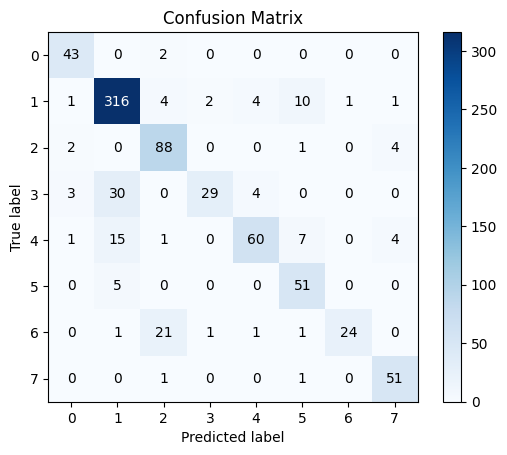

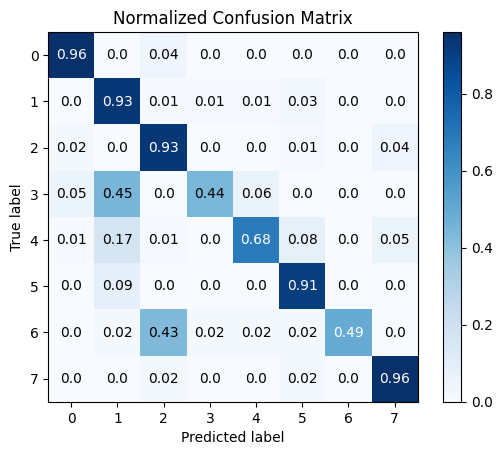

In [ ]:
evaluate_report(test_gen,y_pred = ensemble_pred)